## Mask Extraction

This notebook illustrates instructions to extract segmentation geometries (polygons) in WKT format from a grayscale image mask.

In [8]:
! pip install -r requirements.txt

### imports

In [1]:
import json
import numpy as np

from imantics import Mask
from PIL import Image, ImageDraw

import matplotlib.cm as colormap

from shapely.wkt import loads
from shapely.geometry import Polygon
from shapely.validation import make_valid

### paths

In [2]:
BASE_IMAGE_FILE_PATH = './example/input/example_base.png'
MASK_IMAGE_FILE_PATH = './example/input/example_mask.png'

JSON_OUTPUT_PATH = './example/output/example_mask_wkt.json'

### extract wkt segmentations from mask_image

In [3]:
def extract_wkt_segmentations_from_mask_image(mask_file_path: str) -> list[dict]:
    # load image
    mask_image = Image.open(mask_file_path)
    # extract pixel_array
    pixel_array = np.asarray(mask_image)
    # identify mask pixels
    pixels_values = np.unique(pixel_array) 
    mask_pixels = pixels_values[pixels_values.nonzero()] 

    mask_segmentations = []
    for focus_mask_pixel in mask_pixels:
        # isolate mask pixel
        pixel_array_copy = pixel_array.copy()
        pixel_array_copy[pixel_array_copy != focus_mask_pixel] = 0

        # extract masks
        mask_polygons = Mask(pixel_array_copy).polygons().points

        # post-process masks into valid wkts
        focus_mask_wkts = []
        for mask_polygon in mask_polygons:
            if len(mask_polygon) < 3:
                continue
            mask_polygon = Polygon(mask_polygon)
            valid_mask_polygon = make_valid(mask_polygon)
            simplified_valid_mask_polygon = valid_mask_polygon.simplify(tolerance=2, preserve_topology=True)
            focus_mask_wkts.append(simplified_valid_mask_polygon.wkt)

        # add extracted masks to json object
        focus_mask_dict = {"mask_pixel": focus_mask_pixel.item(), "mask_wkt": focus_mask_wkts}
        mask_segmentations.append(focus_mask_dict)
    return mask_segmentations

In [4]:
mask_segmentations = extract_wkt_segmentations_from_mask_image(MASK_IMAGE_FILE_PATH)
mask_segmentations

[{'mask_pixel': 64,
  'mask_wkt': ['POLYGON ((572 507, 566 512, 566 518, 557 534, 555 561, 548 579, 542 622, 515 716, 505 772, 494 806, 484 822, 483 855, 488 874, 498 883, 546 887, 571 898, 586 898, 608 889, 624 874, 627 867, 627 845, 621 833, 621 825, 608 786, 608 754, 615 703, 618 645, 642 586, 665 563, 666 546, 664 537, 654 526, 585 507, 572 507))']},
 {'mask_pixel': 156,
  'mask_wkt': ['POLYGON ((677 301, 667 308, 642 359, 630 391, 608 420, 578 480, 578 494, 582 505, 636 520, 656 520, 669 516, 681 498, 685 476, 685 447, 691 431, 691 413, 701 385, 733 345, 738 335, 738 325, 731 312, 712 304, 692 305, 677 301))']},
 {'mask_pixel': 255,
  'mask_wkt': ['POLYGON ((729 137, 718 143, 712 152, 685 249, 683 265, 676 269, 672 278, 672 290, 676 296, 705 298, 720 307, 733 305, 749 284, 750 265, 744 251, 742 227, 748 218, 748 209, 755 204, 763 185, 761 170, 754 156, 742 142, 729 137))']}]

### dump extracted mask segmentations as json

In [5]:
def dump_to_json(data, json_output_path):
    with open(json_output_path, "w", encoding="utf-8") as fp:
        json.dump(data, fp, ensure_ascii=False, indent=4)
        
dump_to_json(mask_segmentations, JSON_OUTPUT_PATH)

### visualize extracted wkts on base image

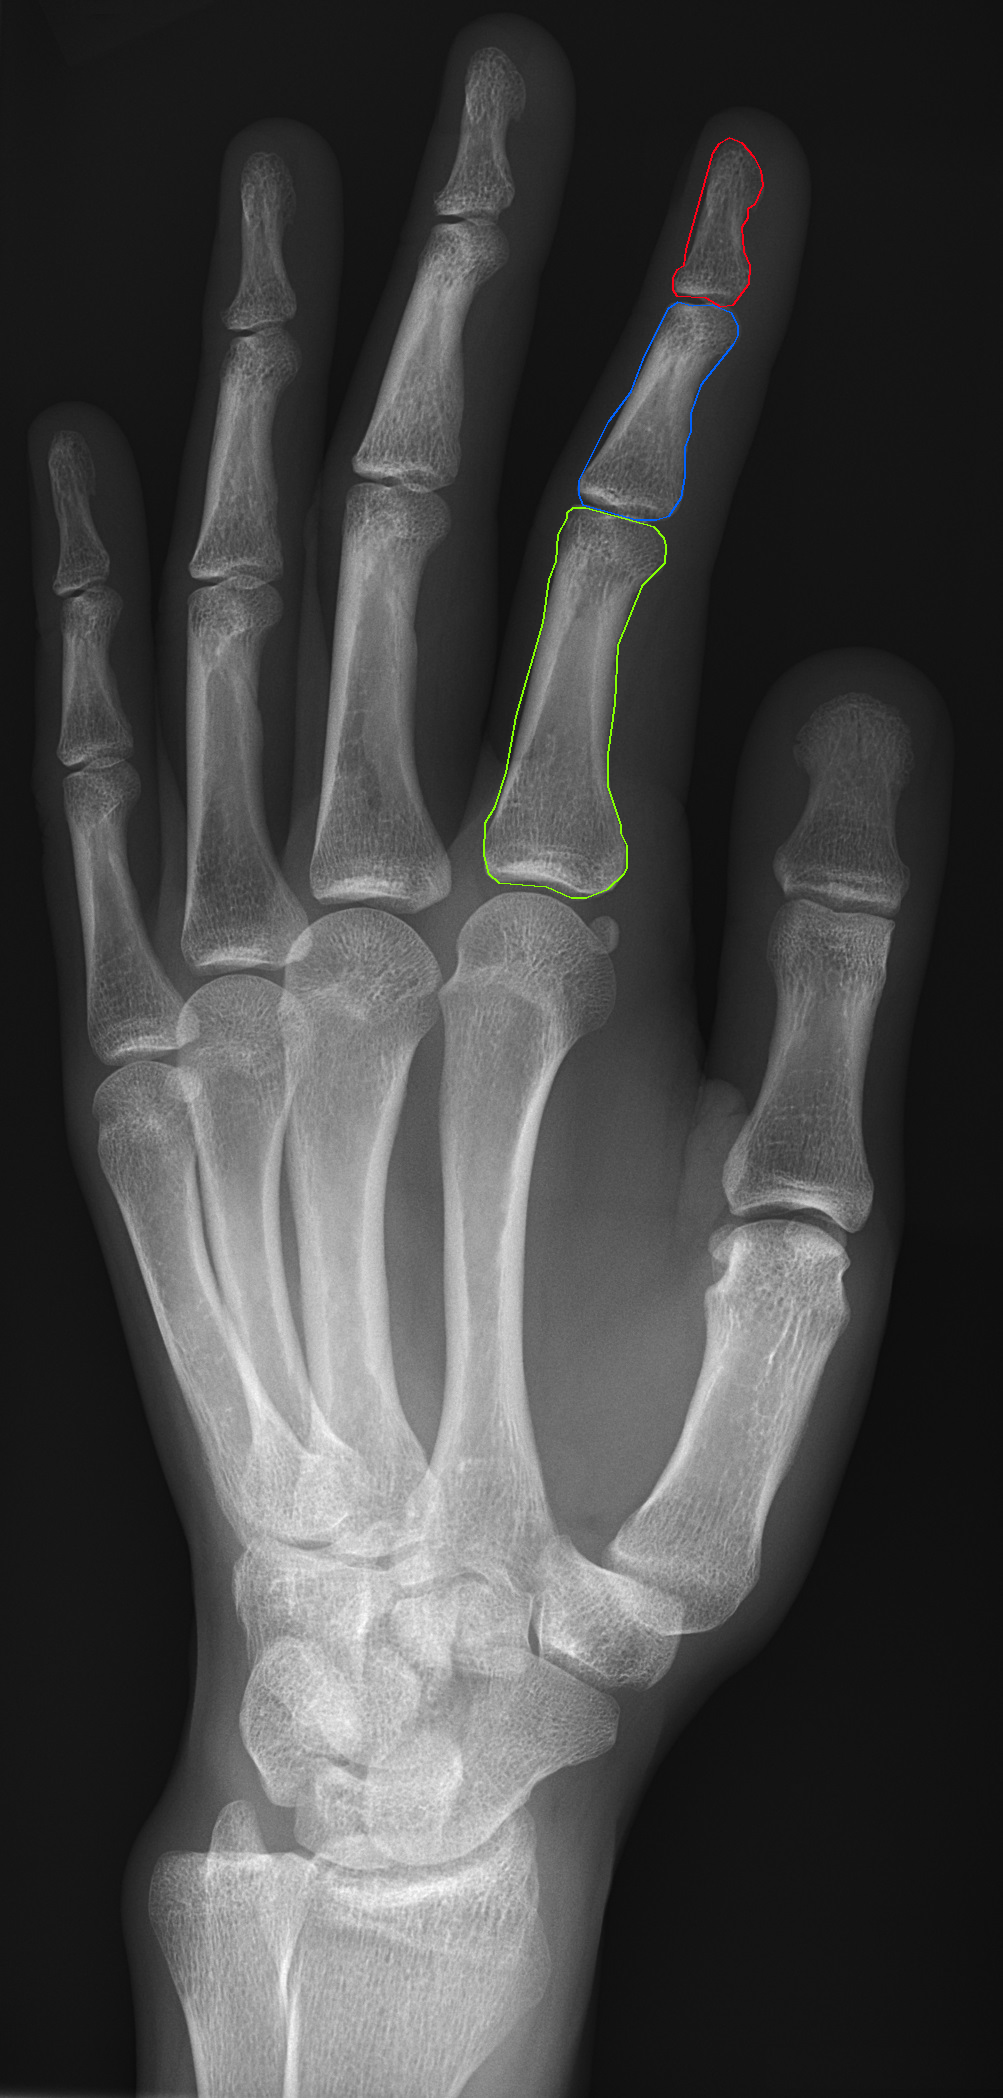

In [6]:
def draw_wkts_on_base_image(base_image: str, mask_segmentations: list[dict]):
    image = Image.open(base_image)
    cmap = colormap.get_cmap('hsv')

    for mask in mask_segmentations:
        for poly in mask["mask_wkt"]:
            poly_coords = list(loads(poly).exterior.coords)
            ImageDraw.Draw(image).polygon(poly_coords, outline = cmap(mask["mask_pixel"], bytes=True), width=2)
    return image

visualized_masks_over_base_image = draw_wkts_on_base_image(BASE_IMAGE_FILE_PATH, mask_segmentations)
visualized_masks_over_base_image